# Cas Kaggle - Predicció obessitat (classificació)
https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster/data

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import time

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.metrics import accuracy_score, make_scorer

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay, classification_report


### Descripció de les variables
- Frequent consumption of high caloric food (FAVC)
- Frequency of consumption of vegetables (FCVC) 
- Number of main meals (NCP)
- Consumption of food between meals (CAEC)
- Consumption of water daily (CH20)
- Consumption of alcohol (CALC). 
- Calories consumption monitoring (SCC)
- Physical activity frequency (FAF)
- Time using technology devices (TUE)
- Transportation used (MTRANS)

## Dividir training i test

In [56]:
# Carregar el CSV en un DataFrame
df_full = pd.read_csv("ObesityDataSet.csv", encoding="utf-8")

# Mostrar les primeres files
df_full



,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [57]:
# Dividir les dades en train i test
X = df_full[[col for col in df_full.columns if col != 'NObeyesdad']]
y = df_full['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1688, 16), (423, 16), (1688,), (423,))

## Explortory data analysis

In [58]:
# Crear un DataFrame que utilitzarem per entrenar i validar els models
df_split = pd.concat([X_train, y_train], axis=1)
# Crear un DataFrame que utilitzarem al final per provar el model triat
df_tester = pd.concat([X_test, y_test], axis=1)

# mostrem el conjunt d'entrenament i validació 
df_split


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
459,Male,19.000000,1.760000,79.000000,yes,yes,2.000000,3.000000,Frequently,no,3.000000,no,1.000000,2.000000,Frequently,Public_Transportation,Overweight_Level_I
426,Male,22.000000,1.750000,70.000000,no,no,2.000000,3.000000,Sometimes,no,3.000000,no,1.000000,1.000000,no,Public_Transportation,Normal_Weight
326,Male,18.000000,1.700000,55.300000,yes,yes,3.000000,3.000000,Sometimes,no,2.000000,no,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
971,Male,19.506389,1.824449,87.656029,yes,yes,2.793561,3.788602,Sometimes,no,2.429059,no,2.094542,0.393358,Sometimes,Public_Transportation,Overweight_Level_I
892,Female,17.085250,1.535618,57.259124,no,yes,1.972545,2.339614,Sometimes,no,1.711074,yes,0.095517,1.191053,Sometimes,Public_Transportation,Overweight_Level_I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Female,25.000000,1.630000,93.000000,no,no,3.000000,4.000000,Always,no,1.000000,no,2.000000,0.000000,no,Public_Transportation,Obesity_Type_II
1439,Female,40.654155,1.529060,79.760922,yes,yes,2.000000,3.000000,Sometimes,no,1.000000,no,0.000000,0.000000,Sometimes,Automobile,Obesity_Type_I
609,Male,19.979810,1.753360,54.997374,yes,yes,2.000000,3.494849,Sometimes,no,2.976672,no,1.949070,2.000000,no,Public_Transportation,Insufficient_Weight
1589,Male,38.523646,1.765836,118.533246,yes,yes,2.177896,2.987652,Sometimes,no,1.745095,no,0.656548,0.000000,Sometimes,Automobile,Obesity_Type_II


In [59]:
print(df_split.describe())

               Age       Height       Weight         FCVC          NCP  \
count  1688.000000  1688.000000  1688.000000  1688.000000  1688.000000   
mean     24.310222     1.701758    86.549808     2.428400     2.688133   
std       6.392643     0.093884    26.053319     0.529317     0.775336   
min      15.000000     1.456346    39.000000     1.000000     1.000000   
25%      19.918283     1.628799    65.137137     2.000000     2.663260   
50%      22.725431     1.701392    83.319978     2.414600     3.000000   
75%      26.000000     1.770000   107.046109     3.000000     3.000000   
max      61.000000     1.980000   160.639405     3.000000     4.000000   

              CH2O          FAF          TUE  
count  1688.000000  1688.000000  1688.000000  
mean      2.017965     1.020554     0.653900  
std       0.613215     0.847575     0.600574  
min       1.000000     0.000000     0.000000  
25%       1.622384     0.132315     0.000000  
50%       2.000000     1.000000     0.619850  
75% 

In [60]:
print("Número d'atributs del dataset:", len(df_split.keys()))
print("Número de files en el train (mostres): ",df_split.shape[0])

Número d'atributs del dataset: 17
Número de files en el train (mostres):  1688


In [61]:
# Mirem valors NaN per atribut
nan_counts = df_split.isna().sum()
var_type = df_split.dtypes
# Mostrem una taula amb els valors NaN i el tipus de variable
print("Valors NaN per atribut i tipus de variable:")
print(pd.DataFrame({"NaN Count": nan_counts, "Variable Type": var_type}))

Valors NaN per atribut i tipus de variable:
                                NaN Count Variable Type
Gender                                  0        object
Age                                     0       float64
Height                                  0       float64
Weight                                  0       float64
family_history_with_overweight          0        object
FAVC                                    0        object
FCVC                                    0       float64
NCP                                     0       float64
CAEC                                    0        object
SMOKE                                   0        object
CH2O                                    0       float64
SCC                                     0        object
FAF                                     0       float64
TUE                                     0       float64
CALC                                    0        object
MTRANS                                  0        object
NObe

No hi ha NANS.

Variables catagòriques:
- Gènere (dona/home) --> binaria
- Historial familiar (si/no) --> binaria
- consum freq d'aliments en calories FAVC (si/no) --> binaria
- Freq de menjar amb carn CAEC (sempre,freqüent, a vegades,no) --> ordinal
- Fumar(sí/no) --> binaria
- Monitorització consum de calories SCC (sí/no) --> binaria
- Consum d'alcohol CALC (sempre,freqüent, a vegades,no) --> ordinal
- Transport (automobil, moto, trans public, caminar, bici)
- Tipus d'obestitat (obesitat tipus 1/2, sobrepres 1/2, pes normal, pes insuficient) --> ordinal

Variables númeriques:
- Edat
- Alçada
- Pes
- Frequencia del consum de verdures (FCVC)
- Número de carns NCP
- Consum d'aigua CH20
- Freq d'activitat física FAF
- Temps d'ús disp tecno TUE


C:\Users\annit\AppData\Local\Temp\ipykernel_59376\3921934752.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\annit\AppData\Local\Temp\ipykernel_59376\3921934752.py:13: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.countplot(
C:\Users\annit\AppData\Local\Temp\ipykernel_59376\3921934752.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
C:\Users\annit\AppData\Local\Temp\ipykernel_59376\3921934752.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\

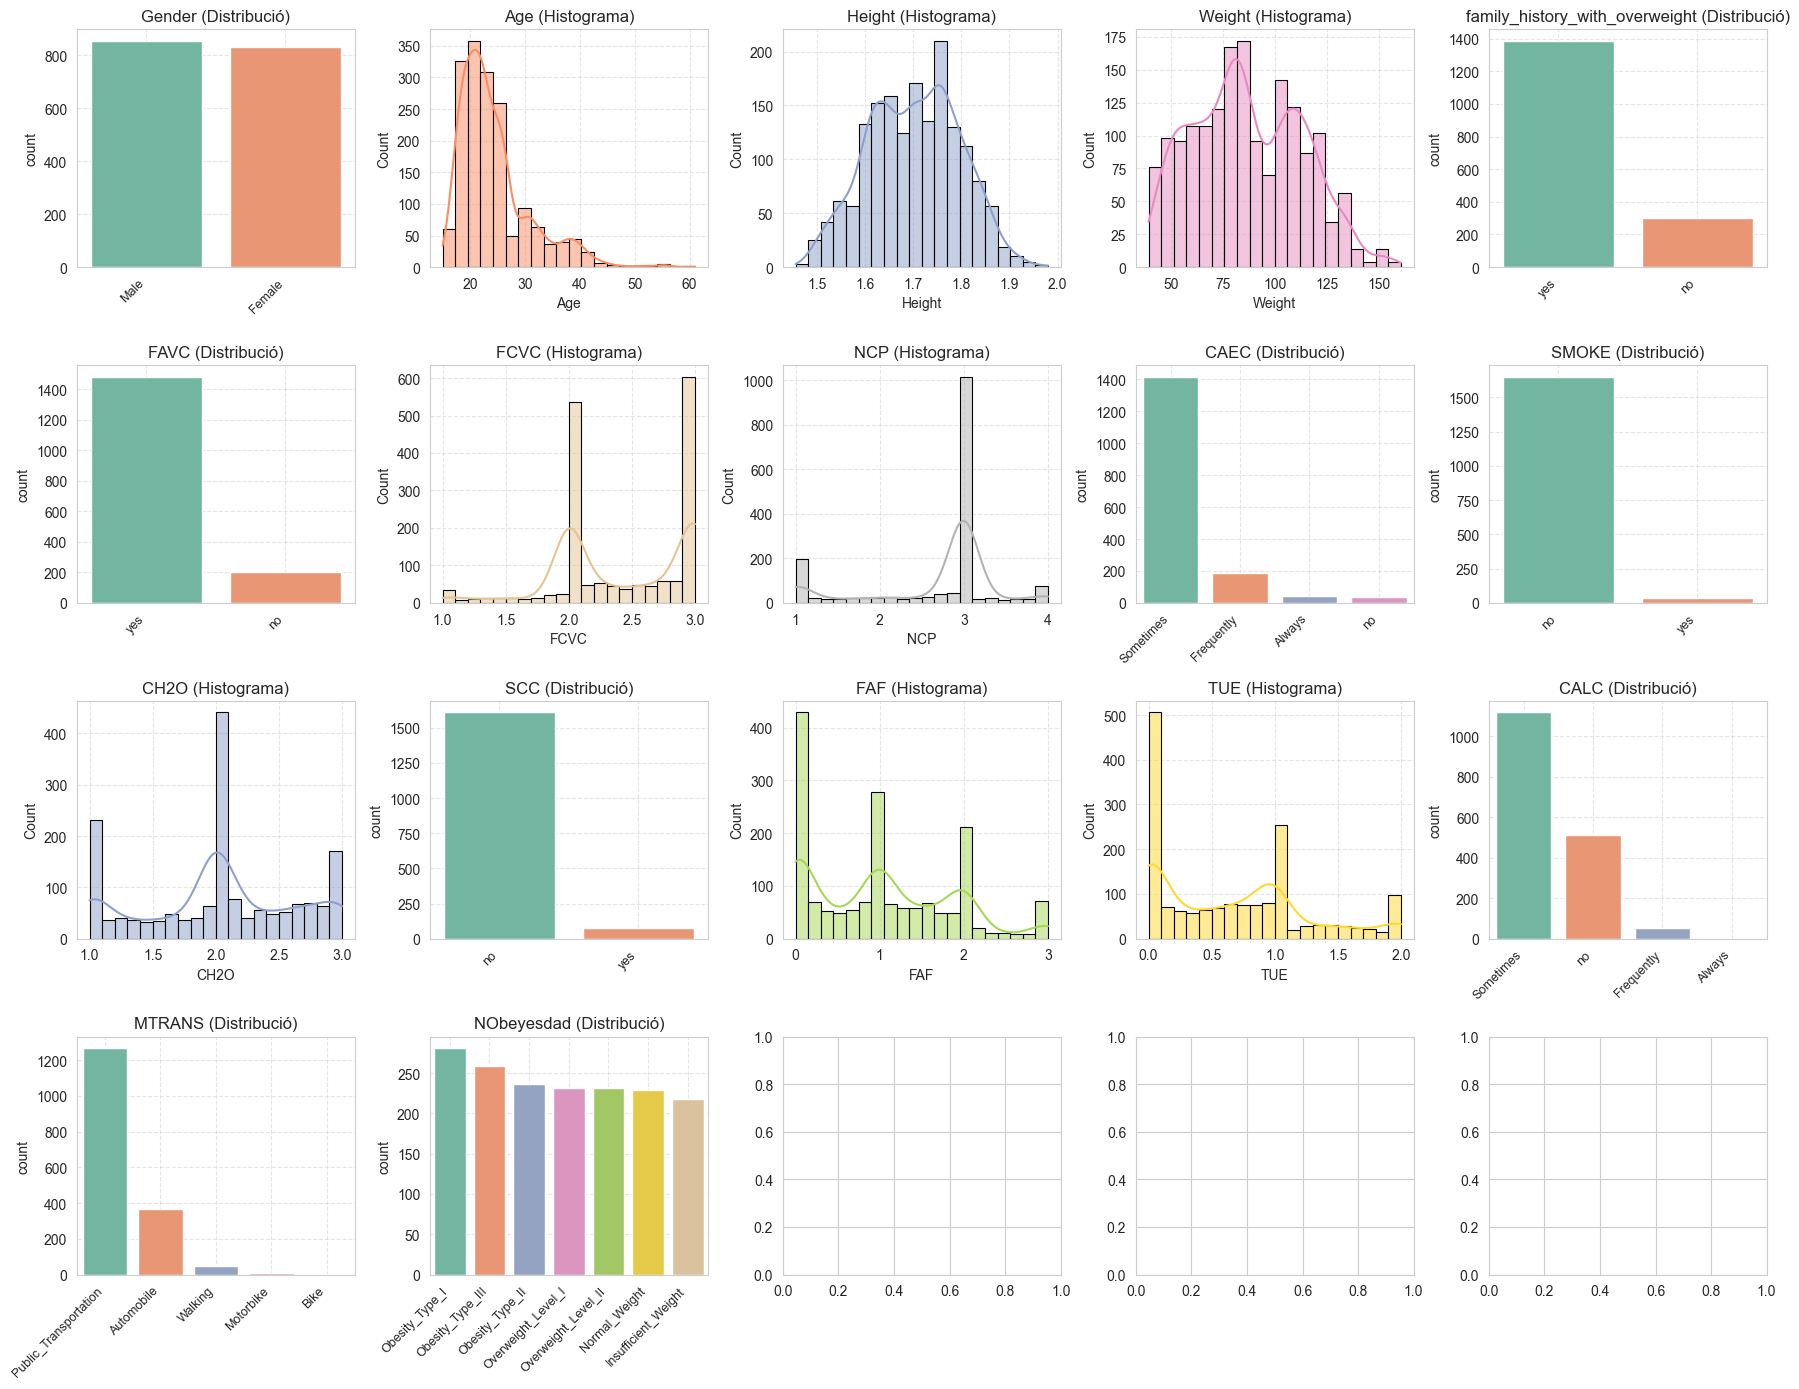

In [62]:
cols = df_tester.columns.tolist()

sns.set_style("whitegrid")
palette = sns.color_palette("Set2")

fig, axes = plt.subplots(4, 5, figsize=(18, 14))
axes = axes.flatten()

for i, col in enumerate(cols[:17]): 
    ax = axes[i]
    
    if (not pd.api.types.is_numeric_dtype(df_tester[col])) or (df_tester[col].nunique() <= 6):
        sns.countplot(
            x=df_split[col], 
            ax=ax, 
            order=df_split[col].value_counts().index, 
            palette=palette
        )
        ax.set_title(f'{col} (Distribució)')
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)

    else:
        sns.histplot(
            data=df_split, 
            x=col, 
            bins=20, 
            kde=True, # Afegim suavització (KDE)
            color=palette[i % len(palette)], # Assigna un color de la paleta
            edgecolor='black',
            ax=ax
        )
        ax.set_title(f'{col} (Histograma)', fontsize=12)
        ax.set_xlabel(col, fontsize=10)

    
    
    ax.grid(True, linestyle='--', alpha=0.5)

for j in range(i + 1, 17):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

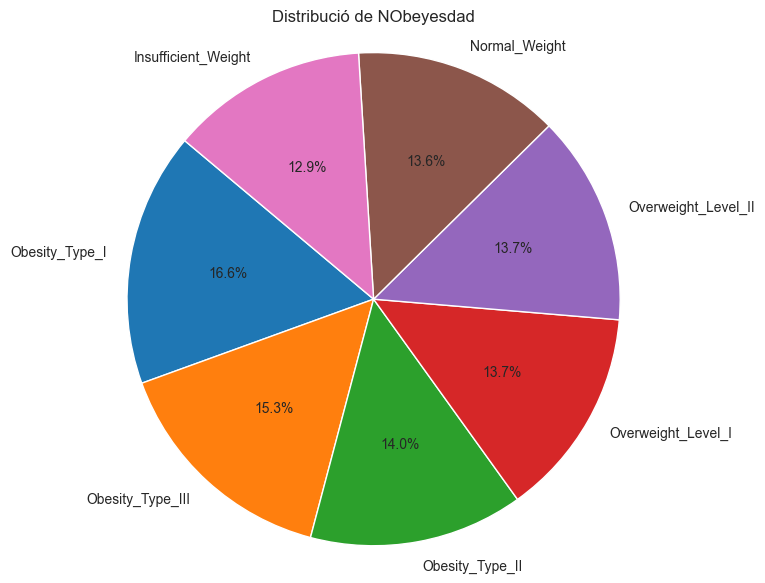

In [63]:
import matplotlib.pyplot as plt

counts = df_split['NObeyesdad'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribució de NObeyesdad')
plt.axis('equal')
plt.show()

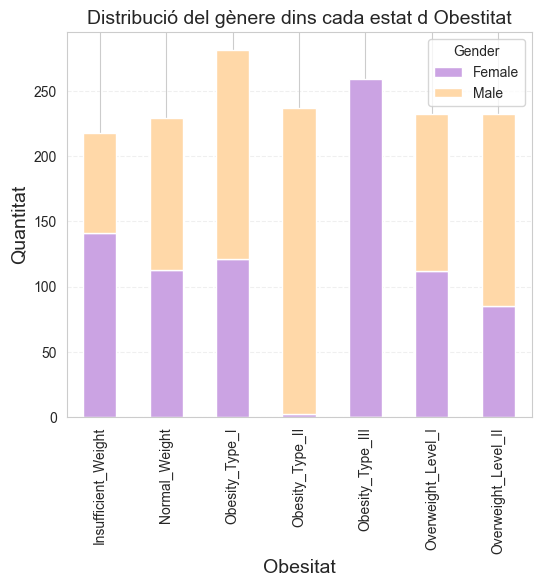

In [64]:
ct_rev = pd.crosstab(df_split["NObeyesdad"], df_split['Gender']) 

ct_rev.plot(kind='bar', stacked=True, 
            color=['#CBA3E3', '#FFD8A8'], 
            figsize=(6,5))

plt.title('Distribució del gènere dins cada estat d Obestitat', fontsize=14)
plt.xlabel('Obesitat', fontsize=14)
plt.ylabel('Quantitat', fontsize=14)
plt.grid(alpha=0.3, axis='y', linestyle='--')
plt.show()

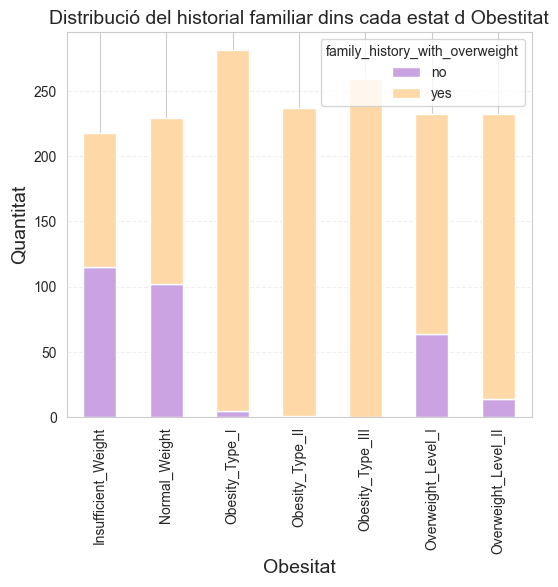

In [65]:
ct_rev = pd.crosstab(df_split["NObeyesdad"], df_split["family_history_with_overweight"]) 

ct_rev.plot(kind='bar', stacked=True, 
            color=['#CBA3E3', '#FFD8A8'], 
            figsize=(6,5))

plt.title('Distribució del historial familiar dins cada estat d Obestitat', fontsize=14)
plt.xlabel('Obesitat', fontsize=14)
plt.ylabel('Quantitat', fontsize=14)
plt.grid(alpha=0.3, axis='y', linestyle='--')
plt.show()

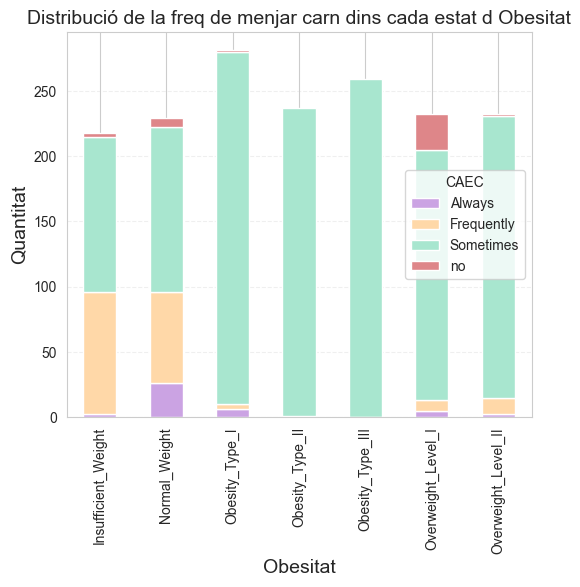

In [66]:
ct_rev = pd.crosstab(df_split["NObeyesdad"], df_split['CAEC'] ) 

ct_rev.plot(kind='bar', stacked=True, color=['#CBA3E3', '#FFD8A8', '#A8E6CF',"#DE8689"],
            figsize=(6,5))

plt.title('Distribució de la freq de menjar carn dins cada estat d Obesitat', fontsize=14)
plt.xlabel('Obesitat', fontsize=14)
plt.ylabel('Quantitat', fontsize=14)
plt.grid(alpha=0.3, axis='y', linestyle='--')
plt.show()

Comentem algo

Mirem si hi ha outliers

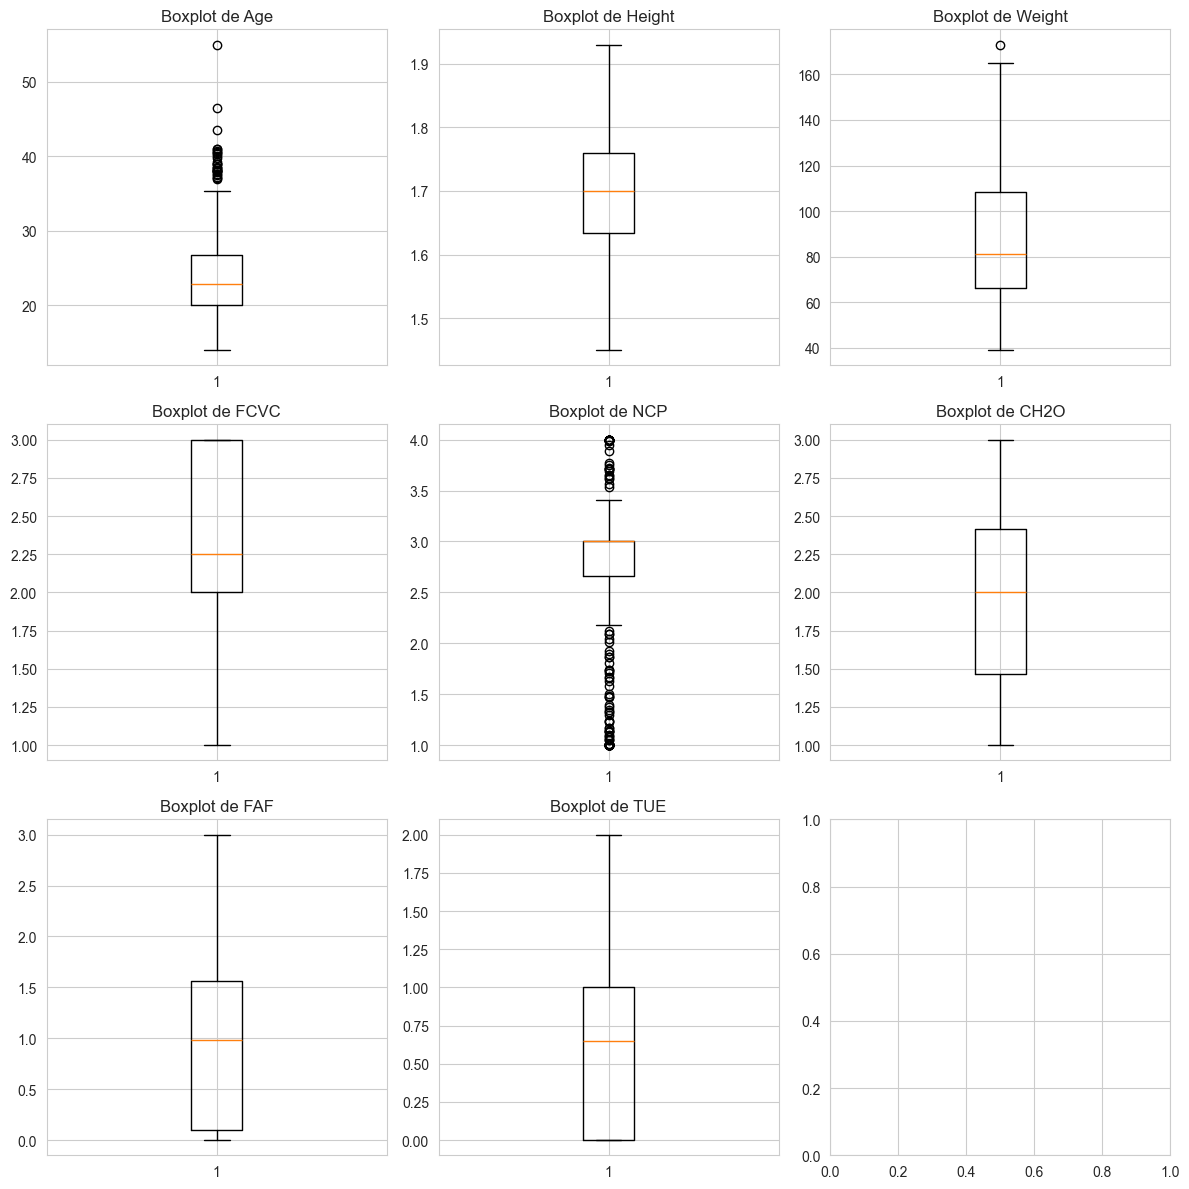

In [67]:
# Seleccionem només les variables numèriques
numeriques = df_tester.select_dtypes(include=['float64', 'int64']).columns

# Definim la quadrícula 3x2
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3 files, 2 columnes
axes = axes.flatten()  # convertim a array 1D per iterar més fàcil

# Fem el boxplot per cada variable
for i, col in enumerate(numeriques[:8]):  # Només 6 variables per a 3x2
    axes[i].boxplot(df_tester[col])
    axes[i].set_title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()

No veiem cap boxplot amb outliers importants, la variable NPC està entre valors del 0 al 4 i age entre 14 i 61. Però al normalitzar utilitzarem el z-score.

In [68]:
df_split = pd.get_dummies(df_split, columns=['MTRANS'])
df_split.head()

bool_cols = df_split.select_dtypes(include='bool').columns
df_split[bool_cols] = df_split[bool_cols].astype(int)

In [69]:
df_split['Gender'] = df_split['Gender'].replace({'Male': 1, 'Female': 0})
df_split['family_history_with_overweight'] = df_split['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
df_split['FAVC'] = df_split['FAVC'].replace({'yes': 1, 'no': 0})
df_split['SMOKE'] = df_split['SMOKE'].replace({'yes': 1, 'no': 0})
df_split['SCC'] = df_split['SCC'].replace({'yes': 1, 'no': 0})
df_split['CALC'] = df_split['CALC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})
df_split['CAEC'] = df_split['CAEC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})

C:\Users\annit\AppData\Local\Temp\ipykernel_59376\632722537.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_split['Gender'] = df_split['Gender'].replace({'Male': 1, 'Female': 0})
C:\Users\annit\AppData\Local\Temp\ipykernel_59376\632722537.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_split['family_history_with_overweight'] = df_split['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
C:\Users\annit\AppData\Local\Temp\ipykernel_59376\632722537.py:3: FutureWarning: Downcasting behavior in `replace` is dep

In [70]:
df_split.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
459,1,19.000000,1.760000,79.000000,1,1,2.000000,3.000000,2,0,...,0,1.000000,2.000000,2,Overweight_Level_I,0,0,0,1,0
426,1,22.000000,1.750000,70.000000,0,0,2.000000,3.000000,1,0,...,0,1.000000,1.000000,0,Normal_Weight,0,0,0,1,0
326,1,18.000000,1.700000,55.300000,1,1,3.000000,3.000000,1,0,...,0,3.000000,0.000000,1,Normal_Weight,0,0,0,1,0
971,1,19.506389,1.824449,87.656029,1,1,2.793561,3.788602,1,0,...,0,2.094542,0.393358,1,Overweight_Level_I,0,0,0,1,0
892,0,17.085250,1.535618,57.259124,0,1,1.972545,2.339614,1,0,...,1,0.095517,1.191053,1,Overweight_Level_I,0,0,0,1,0


La classificació de NObeyesdad s'assigna de la següent manera segons el valor de BMI (body mass index):
- Underweight Less than 18.5
- Normal 18.5 to 24.9
- Overweight 25.0 to 29.9
- Obesity I 30.0 to 34.9
- Obesity II 35.0 to 39.9
- Obesity III Higher than 40

Per calcular el BMI: $ BMI = \frac{weight}{height^2}$. Veiem que per tant el pes com l'alçada tindran una gran influència a l'hora de classificar. Com el que volem és estudiar el pes que tenen la resta de variables no tant obvies, cosiderarem una nova base de dades que no tingui en compte la variable Height ni la variable Weight.

In [71]:
df_new= df_split.copy()
#borrem les variables pes i alçada
df_new= df_new.drop(columns=['Weight', 'Height'])
df_new.describe()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
count,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000
mean,0.506517,24.310222,0.821682,0.879739,2.428400,2.688133,1.138626,0.021919,2.017965,0.046209,1.020554,0.653900,0.729265,0.215640,0.002962,0.004147,0.750592,0.026659
std,0.500106,6.392643,0.382893,0.325362,0.529317,0.775336,0.464228,0.146464,0.613215,0.209999,0.847575,0.600574,0.516058,0.411387,0.054360,0.064282,0.432798,0.161132
min,0.000000,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.918283,1.000000,1.000000,2.000000,2.663260,1.000000,0.000000,1.622384,0.000000,0.132315,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,22.725431,1.000000,1.000000,2.414600,3.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.619850,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,26.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000,2.500827,0.000000,1.683612,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,61.000000,1.000000,1.000000,3.000000,4.000000,3.000000,1.000000,3.000000,1.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Classificació de la variable resposta

In [72]:
target_encoder = LabelEncoder()
df_new['NObeyesdad_encoded'] = target_encoder.fit_transform(df_new['NObeyesdad'])

# Ens desfem de la variable NObeyesdad categòrica
df_clean = df_new.copy().drop(columns = ['NObeyesdad'])

Assignació de `NObeyesdad_encoded`:
- Obesity_Type_I --> 2
- Obesity_Type_II --> 3
- Obesity_Type_III --> 4
- Overweight_Level_I --> 5
- Overweight_Level_II --> 6
- Normal_Weight --> 1
- Insufficient_Weight --> 0



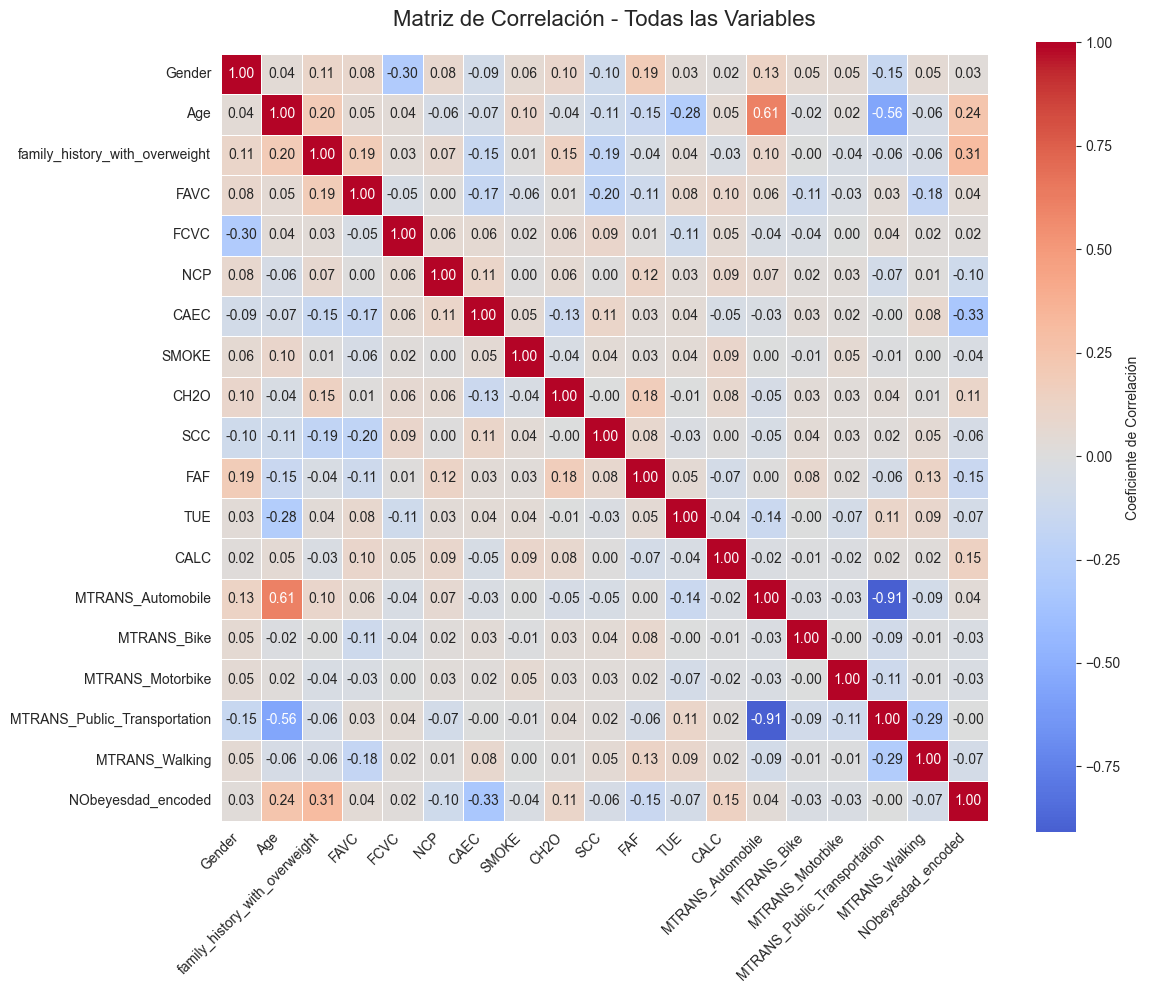

In [73]:
# Crear heatmap completo de correlación entre todas las variables
#df_for_heatmap = df_split.drop('NObeyesdad', axis=1).copy()

# Calcular matriz de correlación
corr_matrix_full = df_clean.corr()

# Crear heatmap de mayor tamaño para que se vean todas las variables
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_full, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f', 
            linewidths=0.5,
            square=True,
            cbar_kws={'label': 'Coeficiente de Correlación'})
plt.title('Matriz de Correlación - Todas las Variables', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


Mirem un histograma general de la distribuició de totes les variables per veure si hem de fer normalització

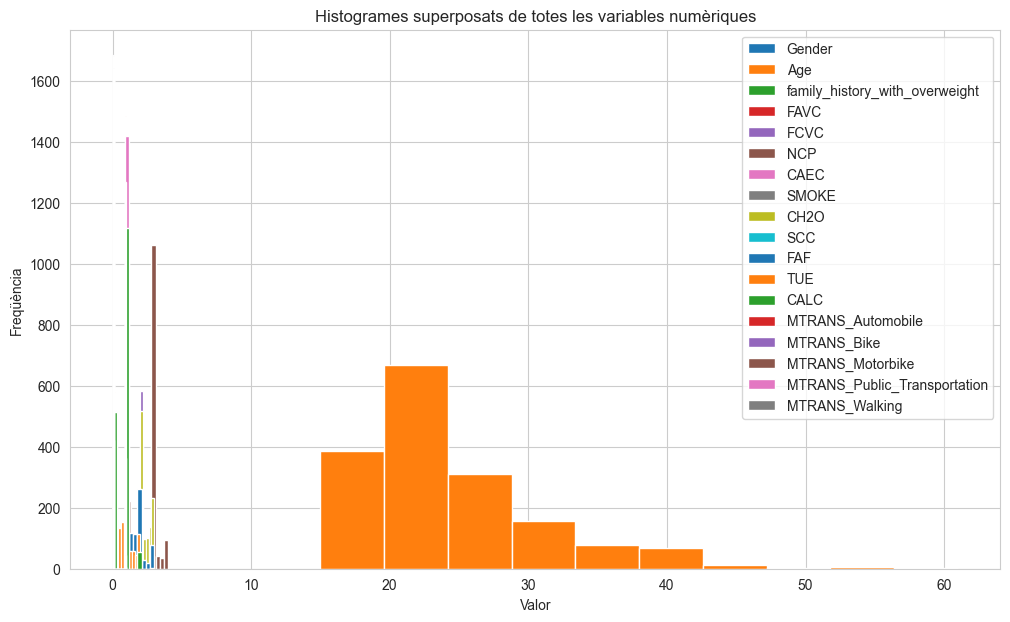

In [74]:
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'NObeyesdad_encoded']

# Fem l'histograma superposat
plt.figure(figsize=(12, 7))

for col in numeric_cols:
    plt.hist(df_clean[col], bins=10, alpha=1, label=col)

plt.title("Histogrames superposats de totes les variables numèriques")
plt.xlabel("Valor")
plt.ylabel("Freqüència")
plt.legend(loc='upper right', fontsize=10)
plt.show()

Per normalitzar, ho hem de fer sobre el conjunt de dades TRAIN. Per això fem primer una separació de train i test per després fer una normalització amb z-score

In [75]:
# Seleccionem només les columnes numèriques
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'NObeyesdad_encoded']

# Transformem a z-score
train_means = {}
train_stds = {}

for col in numeric_cols:
    train_means[col] = df_clean[col].mean()
    train_stds[col] = df_clean[col].std()
    df_clean[col] = (df_clean[col] - train_means[col]) / train_stds[col]



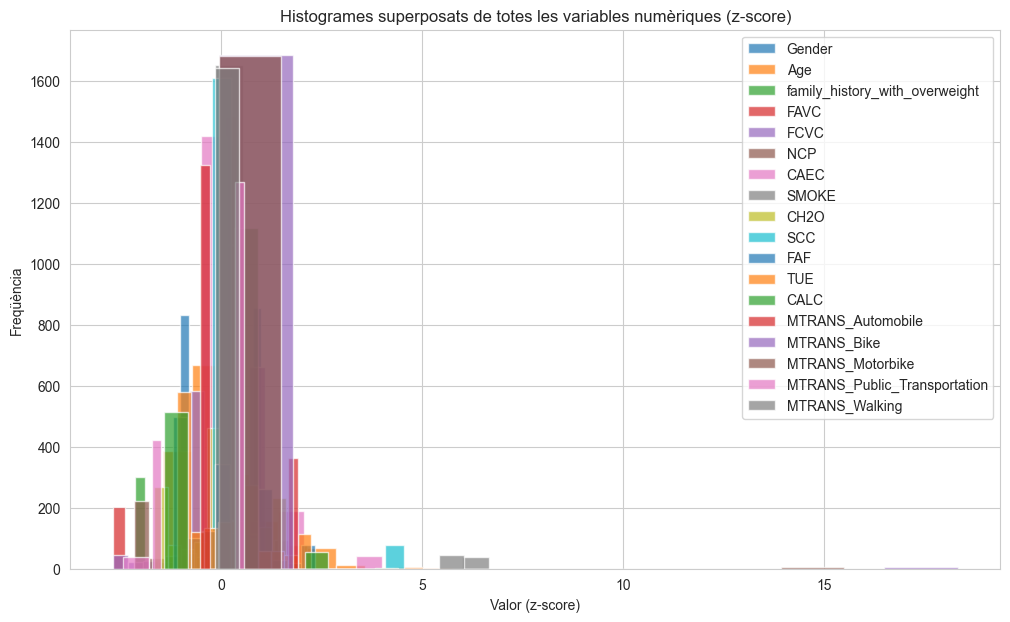

In [76]:

# Fem l'histograma superposat
plt.figure(figsize=(12, 7))

for col in numeric_cols:
    plt.hist(df_clean[col], bins=10, alpha=0.7, label=col)  # alpha=0.5 per veure superposició

plt.title("Histogrames superposats de totes les variables numèriques (z-score)")
plt.xlabel("Valor (z-score)")
plt.ylabel("Freqüència")
plt.legend(loc='upper right', fontsize=10)
plt.show()


Un cop tenim les dades normalitzades mirem si cal eliminar alguna variable. Provarem diferents mètodes:
- Lasso
- Ridge
- Elastic Net
- Feature selection de random forest

### Lasso

In [77]:
X= df_clean[[col for col in df_clean.columns if col != 'NObeyesdad_encoded']]
y= df_clean['NObeyesdad_encoded']
model_lasso = Lasso(alpha=0.05)
model_lasso.fit(X, y)

coef = pd.Series(model_lasso.coef_, index=X.columns)
print("\nCoeficients del model LASSO:")
display(coef.sort_values(key=abs, ascending=False).to_frame("Pes de la variable"))


Coeficients del model LASSO:


,Pes de la variable
CAEC,-0.478855
family_history_with_overweight,0.434883
Age,0.366379
CALC,0.217851
MTRANS_Public_Transportation,0.158318
FAF,-0.131226
NCP,-0.104986
FAVC,-0.094599
CH2O,0.056610
SMOKE,-0.054996


Potser Lasso no acaba de ser del tot eficient ja que tenim algunes variables altament correlacionades:
- MTRANS_Automobile - Age
- MTRANS_Public_Transportation - Age
- MTRANS_Automobile - MTRANS_Public_Transportation
- Hight - Gender

### Ridge

In [78]:
model_ridge = Ridge()
model_ridge.fit(X,y)

coef = pd.Series(model_ridge.coef_, index=X.columns)
print("\nCoeficients del model Ridge:")
display(coef.sort_values(key=abs, ascending=False).to_frame("Pes de la variable"))


Coeficients del model Ridge:


,Pes de la variable
CAEC,-0.514167
family_history_with_overweight,0.485232
Age,0.478924
CALC,0.269737
FAF,-0.174449
FAVC,-0.172579
NCP,-0.145157
MTRANS_Public_Transportation,0.140935
MTRANS_Automobile,-0.128635
SMOKE,-0.126675


### Feature selection - Random Forest

,Pes de la variable
Age,0.161313
FCVC,0.137903
FAF,0.097527
NCP,0.095680
TUE,0.094826
CH2O,0.089958
Gender,0.066183
CAEC,0.054443
CALC,0.053235
family_history_with_overweight,0.048958


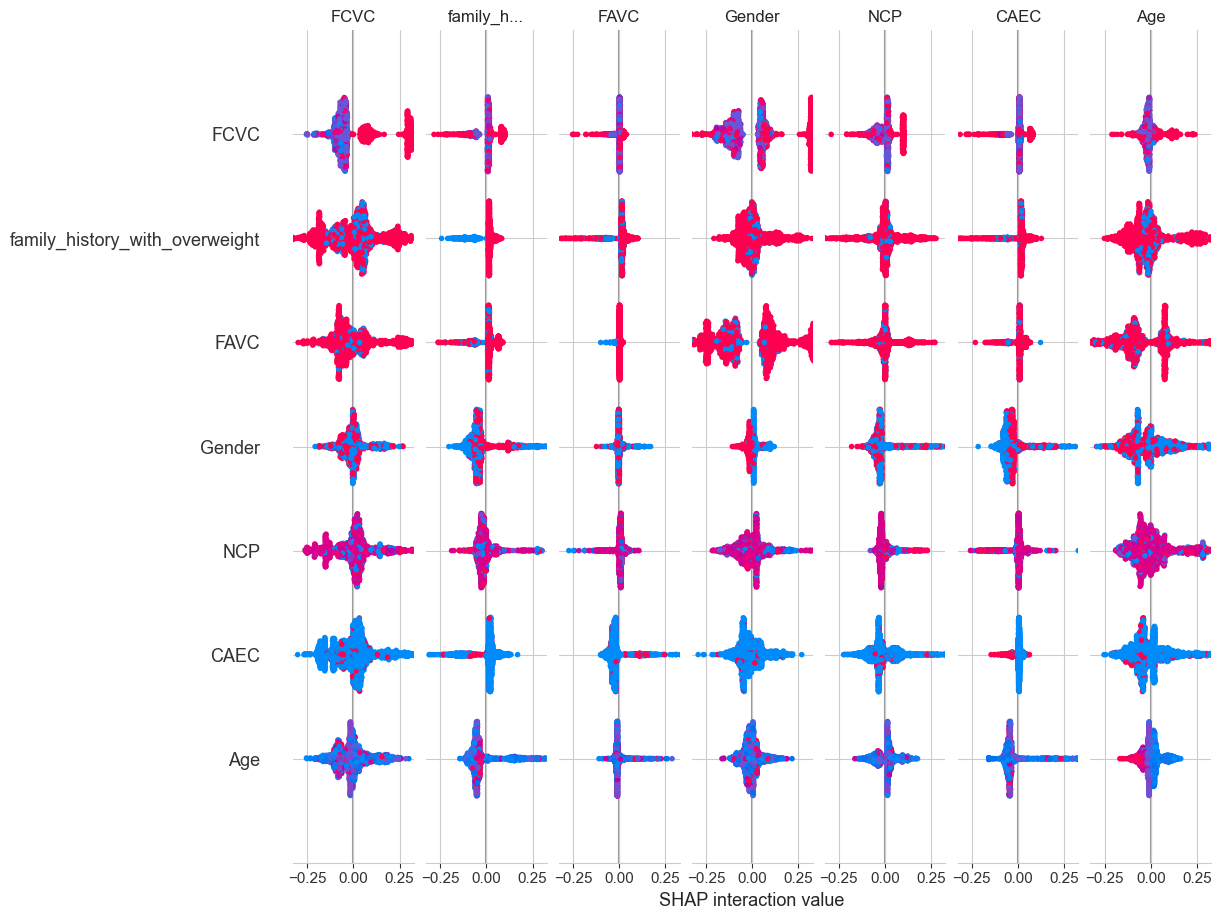

None


In [79]:
#Si vols selecció de variables fiable per prediccions, sobretot amb pocs features (21) i combinacions complexes → SHAP és millor.
#Random Forest feature importance està bé per un primer filtratge ràpid, però no és tan fiable com SHAP quan hi ha correlacions o interaccions.
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
display(importances.sort_values(ascending=False).to_frame("Pes de la variable"))

import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)
print(shap.summary_plot(shap_values, X,max_display=10))

Lasso considera les variables CAEC i family_history_with_overweight amb més pes i Random forest, Age i FCVC.

Ens quedem amb les variables que ha predit el random forest /shap ja que té en compte també relacions no lineals.

Base de dades reduïda

In [80]:
df_reduit = df_clean.copy()

In [81]:
X_red = df_reduit[[c for c in df_reduit.columns if c != 'NObeyesdad_encoded']]
y_red = df_reduit['NObeyesdad_encoded']

## Metric Selection

-Average Precision Score: Mesura l’àrea sota la corba Precision–Recall per cada classe. És més útil en problemes binaris o desequilibrats; amb 6 categories balancejades aporta poc valor.

- F1 Score (amb threshold): Combina precisió i recall per cada classe i després es pot fer una mitjana (macro F1) per resumir el rendiment global. Seria una opció utilitzar macro F1

- Precision: Proporció de prediccions d’una classe concreta que són correctes. Indica si el model “s’equivoca” etiquetant altres classes com aquesta.

- Recall: Proporció de mostres reals d’una classe que el model identifica correctament. Mostra si se’n deixa de reconèixer alguna.

- Accuracy: Percentatge de prediccions correctes sobre totes les mostres, summant totes les classes. És fàcil d’interpretar i, en aquest cas amb 6 categories gairebé equilibrades, reflecteix bé el rendiment global.

En el nostre estudi volem conèixer amb el mateix nivell d’importància tots els tipus d’errors i encerts (falsos positius, falsos negatius, veritables positius i veritables negatius),per tant creiem que F1-score i accuracy poden ser dues mètriques adeqüades. 

F1-score és molt útil quan les classes estan desbalancejades, però a l'estar equilibrades i no prioritzar cap classe per sobre de les altres, hem decidit utilitzar accuracy ja que així ens podem beneficiar de la seva interpretabilitat. Els resultats d'accuracy són més fàcils d'interpretar que el F1-score.

## Model selection

- Random Forest
- Gradient Boosting (XGBoost,LightGBM)
- SVM (Onee-vs-Rest)
- KNN
- Regresió Logistica (One-vs-Rest)

## Validació Creuada

In [82]:
models = {
        "RandomForestClassifier": RandomForestClassifier(),
        "LGBM": LGBMClassifier(),
        "XGB": XGBClassifier(),
        "SVC":  OneVsRestClassifier(SVC()),
        "KNN": KNeighborsClassifier(),
        "LogisticRegression (OvR)": OneVsRestClassifier(LogisticRegression())

}
cv_scores = {'RandomForestClassifier': [], 'LGBM': [], 'XGB': [], 'SVC': [], 'KNN': [], 'LogisticRegression (OvR)': []}
cv_scores_mean =  {'RandomForestClassifier': [], 'LGBM': [], 'XGB': [], 'SVC': [], 'KNN': [], 'LogisticRegression (OvR)': []}
test_scores =  {'RandomForestClassifier': [], 'LGBM': [], 'XGB': [], 'SVC': [], 'KNN': [], 'LogisticRegression (OvR)': []}
total_times = {'RandomForestClassifier': [], 'LGBM': [], 'XGB': [], 'SVC': [], 'KNN': [], 'LogisticRegression (OvR)': []}

cv = KFold(n_splits=5,shuffle=True) 
accuracy_scorer = make_scorer(accuracy_score)

for name, model in models.items():
    start_time = time.time()
    cv_accuracy_values = cross_val_score(model, X_red, y_red, cv=cv, scoring= accuracy_scorer)
    end_time = time.time()
    
    cv_scores[name].extend(cv_accuracy_values)            # per al boxplot
    cv_scores_mean[name].append(cv_accuracy_values.mean())  # per a la taula
    total_times[name].append(end_time - start_time)


# Crear taula resum amb mitjanes
results = pd.DataFrame({
    'Model': ['RandomForestClassifier', 'LGBM', 'XGB', 'SVC', 'KNN', 'LogisticRegression (OvR)'],
    'Validació accuracy (mitjana)': [
        np.mean(cv_scores_mean['RandomForestClassifier']),
        np.mean(cv_scores_mean['LGBM']),
        np.mean(cv_scores_mean['XGB']),
        np.mean(cv_scores_mean['SVC']),
        np.mean(cv_scores_mean['KNN']),
        np.mean(cv_scores_mean['LogisticRegression (OvR)']),


    ],
    'Temps total (s)': [  # canviat el nom
        np.mean(total_times['RandomForestClassifier']),
        np.mean(total_times['LGBM']),
        np.mean(total_times['XGB']),
        np.mean(total_times['SVC']),
        np.mean(total_times['KNN']),
        np.mean(total_times['LogisticRegression (OvR)']),

    ]
})

# Mostrar taula formatejada
styled = (
    results.style
    .set_caption("Comparació de models amb accuracy i temps total (validació creuada 5-fold)")
    .format({
        'Validació accuracy (mitjana)': '{:.3f}',
        'Temps total (s)': '{:.4f}'
    })
)

styled

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 1350, number of used features: 16
[LightGBM] [Info] Start training from score -2.072061
[LightGBM] [Info] Start training from score -2.009363
[LightGBM] [Info] Start training from score -1.787325
[LightGBM] [Info] Start training from score -1.966113
[LightGBM] [Info] Start training from score -1.875141
[LightGBM] [Info] Start training from score -1.992924
[LightGBM] [Info] Start training from score -1.945170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

,Model,Validació accuracy (mitjana),Temps total (s)
0,RandomForestClassifier,0.842,0.9396
1,LGBM,0.838,1.9705
2,XGB,0.823,1.9893
3,SVC,0.723,0.7609
4,KNN,0.723,0.1522
5,LogisticRegression (OvR),0.565,0.1523


C:\Users\annit\AppData\Local\Temp\ipykernel_59376\1706774320.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_scores[m] for m in models.keys()], labels=models.keys())


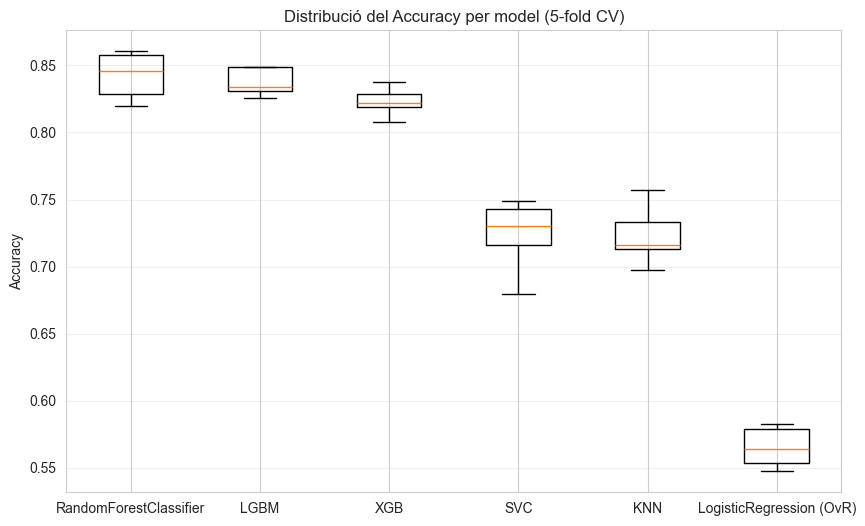

In [83]:
plt.figure(figsize=(10,6))
plt.boxplot([cv_scores[m] for m in models.keys()], labels=models.keys())
plt.ylabel("Accuracy")
plt.title("Distribució del Accuracy per model (5-fold CV)")
plt.grid(axis='y', alpha=0.3)
plt.show()

Descartem el Logistic Regression per un valor de la metrica molt dolent

## Hiperparàmetres

Random Forest

In [84]:
# Hiperparàmetres
param_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    n_iter=100,
    param_distributions=param_rf,
    scoring='accuracy',   # mètrica que feu servir al vostre estudi
    cv=cv,
    n_jobs=-1
)

# Entrenar i buscar millors hiperparàmetres
random_search_rf.fit(X_red, y_red)

# Resultats
print("Millors hiperparàmetres trobats RandomForest:")
print(random_search_rf.best_params_)
print(f"Accuracy Validació (mitjana): {random_search_rf.best_score_:.4f}")


c:\Users\annit\OneDrive\Escritorio\UNI\MATCAD\QUART\APRENENTATGE COMP\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Millors hiperparàmetres trobats RandomForest:
{'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None}
Accuracy Validació (mitjana): 0.8478


LGM

In [85]:
# Hiperparàmetres
param_lgbm = {
    'num_leaves': [15, 31, 63],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 400]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_lgbm = RandomizedSearchCV(
    LGBMClassifier(random_state=42),
    n_iter=20,
    param_distributions=param_lgbm,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)

# Entrenar i buscar millors hiperparàmetres
random_search_lgbm.fit(X_red, y_red)

# Resultats
print("Millors hiperparàmetres trobats LGBMClassifier:")
print(random_search_lgbm.best_params_)
print(f"Accuracy Validació (mitjana): {random_search_lgbm.best_score_:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 1688, number of used features: 16
[LightGBM] [Info] Start training from score -2.046805
[LightGBM] [Info] Start training from score -1.997578
[LightGBM] [Info] Start training from score -1.792945
[LightGBM] [Info] Start training from score -1.963240
[LightGBM] [Info] Start training from score -1.874472
[LightGBM] [Info] Start training from score -1.984562
[LightGBM] [Info] Start training from score -1.984562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

XGB

In [86]:
param_xgb_clf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_xgb_clf = RandomizedSearchCV(
    XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42),
    n_iter=80,
    param_distributions=param_xgb_clf,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)

random_search_xgb_clf.fit(X_red, y_red)

print("Millors hiperparàmetres trobats XGBClassifier:")
print(random_search_xgb_clf.best_params_)
print(f"Accuracy Validació (mitjana): {random_search_xgb_clf.best_score_:.4f}")


c:\Users\annit\OneDrive\Escritorio\UNI\MATCAD\QUART\APRENENTATGE COMP\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=80. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Millors hiperparàmetres trobats XGBClassifier:
{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}
Accuracy Validació (mitjana): 0.8341


SVM

In [87]:
param_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],   # només afecta rbf i poly         
}

random_search_svc = RandomizedSearchCV(
    SVC(decision_function_shape='ovr',random_state=42),
    param_distributions=param_svc,
    n_iter=60,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)

random_search_svc.fit(X_red, y_red)

print("Millors hiperparàmetres trobats SVC:")
print(random_search_svc.best_params_)
print(f"Accuracy Validació (mitjana): {random_search_svc.best_score_:.4f}")

c:\Users\annit\OneDrive\Escritorio\UNI\MATCAD\QUART\APRENENTATGE COMP\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=60. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Millors hiperparàmetres trobats SVC:
{'kernel': 'rbf', 'gamma': 'auto', 'C': 100}
Accuracy Validació (mitjana): 0.7945


KNN

In [88]:
from sklearn.neighbors import KNeighborsClassifier

param_knn = param = {
    'n_neighbors': [5,7,9,11,13,15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

random_search_knn = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_knn,
    scoring='accuracy',
    n_iter=200,
    cv=cv,
    n_jobs=-1
)

random_search_knn.fit(X_red, y_red)

print("Millors hiperparàmetres trobats KNN:")
print(random_search_knn.best_params_)
print(f"Accuracy Validació (mitjana): {random_search_knn.best_score_:.4f}")


c:\Users\annit\OneDrive\Escritorio\UNI\MATCAD\QUART\APRENENTATGE COMP\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Millors hiperparàmetres trobats KNN:
{'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}
Accuracy Validació (mitjana): 0.7915


## Comparació d'algorismes amb validació Creuada i els millors hiperparàmetres

In [89]:
models_best = {
    "RandomForest": random_search_rf.best_estimator_,
    "XGBoost": random_search_xgb_clf.best_estimator_,
    "LightGBM": random_search_lgbm.best_estimator_,
    "SVC": random_search_svc.best_estimator_,
    "KNN": random_search_knn.best_estimator_,
}
cv_scores = {name: [] for name in models_best}
cv_scores_mean = {name: [] for name in models_best}
total_times = {name: [] for name in models_best}

cv = KFold(n_splits=5,shuffle=True) 
accuracy_scorer = make_scorer(accuracy_score)

for name, model in models_best.items():
    start_time = time.time()
    cv_rmse_values = cross_val_score(model, X_red, y_red, cv=cv, scoring= accuracy_scorer)
    end_time = time.time()
    
    cv_scores[name].extend(cv_rmse_values)
    cv_scores_mean[name].append((cv_rmse_values).mean())
    total_times[name].append(end_time - start_time)

# --- 4. Crear taula resum amb mitjanes ---
results = pd.DataFrame({
    'Model': list(models_best.keys()),
    'Validació Accuracy (mitjana)': [np.mean(cv_scores_mean[name]) for name in models_best],
    'Temps total (s)': [np.mean(total_times[name]) for name in models_best]
})

# --- 5. Mostrar taula formatejada ---
styled = (
    results.style
    .set_caption("Comparació de models amb Accuracy i temps total (validació creuada 5-fold)")
    .format({
        'Train CV Accuracy (mitjana)': '{:.3f}',
        'Temps total (s)': '{:.4f}'
    })
)
styled

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 1350, number of used features: 16
[LightGBM] [Info] Start training from score -2.014903
[LightGBM] [Info] Start training from score -2.048805
[LightGBM] [Info] Start training from score -1.800688
[LightGBM] [Info] Start training from score -1.987504
[LightGBM] [Info] Start training from score -1.856002
[LightGBM] [Info] Start training from score -1.940002
[LightGBM] [Info] Start training from score -1.998374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

,Model,Validació Accuracy (mitjana),Temps total (s)
0,RandomForest,0.843027,2.1250
1,XGBoost,0.822273,4.2706
2,LightGBM,0.827579,11.3922
3,SVC,0.776654,0.3389
4,KNN,0.787314,0.1102


C:\Users\annit\AppData\Local\Temp\ipykernel_59376\2001416670.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_scores[m] for m in models_best.keys()], labels=models_best.keys())


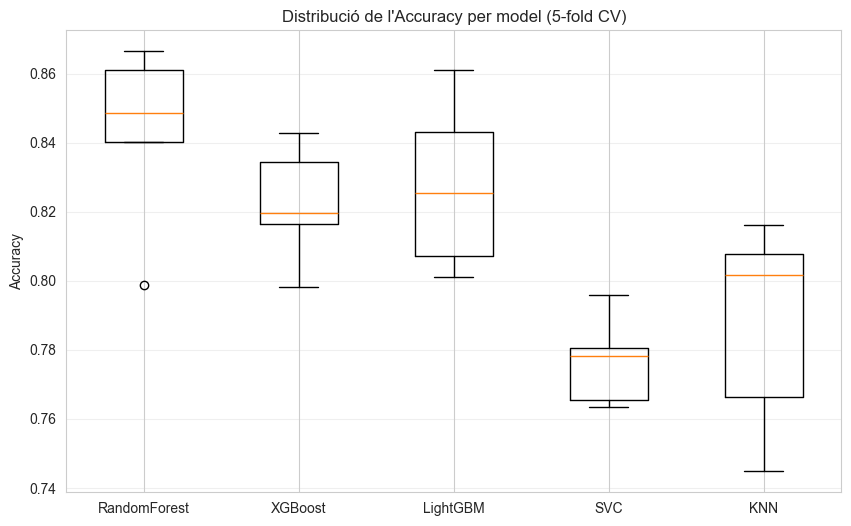

In [90]:
plt.figure(figsize=(10,6))
plt.boxplot([cv_scores[m] for m in models_best.keys()], labels=models_best.keys())
plt.ylabel("Accuracy")
plt.title("Distribució de l'Accuracy per model (5-fold CV)")
plt.grid(axis='y', alpha=0.3)
plt.show()

Escollim com a millor model el Random Forest amb els hiperparàmetres n_estimators: 100, min_samples_split: 2, max_depth: None. En la majoria de casos ens dona millor mitjana i mediana.

## Anàlisi final

Preparem el dataset que ens servirà per fer el test

In [91]:
df_tester

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
572,Female,19.084967,1.768435,49.597765,no,yes,3.000000,3.725797,Sometimes,no,1.191401,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
370,Male,19.000000,1.800000,60.000000,no,yes,2.000000,3.000000,Sometimes,no,1.000000,no,1.000000,1.000000,no,Public_Transportation,Normal_Weight
1002,Male,24.108711,1.700000,80.761409,yes,yes,2.000000,3.000000,Sometimes,no,2.879402,no,0.000000,0.322405,Sometimes,Public_Transportation,Overweight_Level_II
1837,Female,20.941943,1.812963,138.730619,yes,yes,3.000000,3.000000,Sometimes,no,2.641489,no,0.481555,0.735201,Sometimes,Public_Transportation,Obesity_Type_III
1724,Male,33.293166,1.696412,103.250355,yes,yes,2.679664,2.415522,Sometimes,no,1.000000,no,1.987296,0.000000,no,Public_Transportation,Obesity_Type_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,Male,30.628650,1.766975,118.363376,yes,yes,2.964319,3.000000,Sometimes,no,2.377257,no,0.614959,1.875023,Sometimes,Automobile,Obesity_Type_II
1161,Male,18.181821,1.662669,79.863546,yes,no,2.492758,2.270163,Sometimes,no,1.992586,no,1.452467,0.864583,no,Public_Transportation,Overweight_Level_II
1537,Male,30.870724,1.670774,101.626189,yes,yes,2.907744,3.990925,Sometimes,no,1.000000,no,1.999750,0.000000,no,Public_Transportation,Obesity_Type_II
497,Male,20.000000,1.560000,45.000000,no,no,2.000000,3.000000,Sometimes,no,2.000000,no,1.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight


In [92]:
# Fem One-Hot-Encoding per la variable MTRANS
df_tester = pd.get_dummies(df_tester, columns=['MTRANS'])
bool_cols = df_tester.select_dtypes(include='bool').columns
df_tester[bool_cols] = df_tester[bool_cols].astype(int)

# Convertim en numèriques les variables categòriques
df_tester['Gender'] = df_tester['Gender'].replace({'Male': 1, 'Female': 0})
df_tester['family_history_with_overweight'] = df_tester['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
df_tester['FAVC'] = df_tester['FAVC'].replace({'yes': 1, 'no': 0})
df_tester['SMOKE'] = df_tester['SMOKE'].replace({'yes': 1, 'no': 0})
df_tester['SCC'] = df_tester['SCC'].replace({'yes': 1, 'no': 0})
df_tester['CALC'] = df_tester['CALC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})
df_tester['CAEC'] = df_tester['CAEC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})

# Regressió de la variable resposta segons l'encondig utilitzat abans (train)
df_tester['NObeyesdad_encoded'] = df_tester['NObeyesdad'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4})



C:\Users\annit\AppData\Local\Temp\ipykernel_59376\4291503385.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tester['Gender'] = df_tester['Gender'].replace({'Male': 1, 'Female': 0})
C:\Users\annit\AppData\Local\Temp\ipykernel_59376\4291503385.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tester['family_history_with_overweight'] = df_tester['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
C:\Users\annit\AppData\Local\Temp\ipykernel_59376\4291503385.py:9: FutureWarning: Downcasting behavior in `replace`

In [93]:
# treiem la variable pes i alçada
df_tester = df_tester.drop(columns=['Weight', 'Height'])


In [94]:
#borrem nobeyesdad
df_tester = df_tester.drop(columns=['NObeyesdad'])

In [95]:
#Normalitzem les variables d'entrada utilitzant les mitjanes i desviacions estàndard del train
numeric_cols = df_tester.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'NObeyesdad_encoded']
for col in numeric_cols:
        df_tester[col] = (df_tester[col] - train_means[col]) / train_stds[col]

In [96]:
df_tester

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad_encoded
572,-1.012819,-0.817386,-2.145983,0.369621,1.079882,1.338340,-0.298615,-0.149658,-1.347918,-0.220042,1.155586,0.576283,0.524621,-0.524177,-0.05449,-0.064511,0.576267,-0.165447,0
370,0.986758,-0.830677,-2.145983,0.369621,-0.809345,0.402234,-0.298615,-0.149658,-1.660045,-0.220042,-0.024250,0.576283,-1.413147,-0.524177,-0.05449,-0.064511,0.576267,-0.165447,1
1002,0.986758,-0.031522,0.465711,0.369621,-0.809345,0.402234,-0.298615,-0.149658,1.404787,-0.220042,-1.204086,-0.551963,0.524621,-0.524177,-0.05449,-0.064511,0.576267,-0.165447,6
1837,-1.012819,-0.526899,0.465711,0.369621,1.079882,0.402234,-0.298615,-0.149658,1.016811,-0.220042,-0.635930,0.135373,0.524621,-0.524177,-0.05449,-0.064511,0.576267,-0.165447,4
1724,0.986758,1.405200,0.465711,0.369621,0.474694,-0.351604,-0.298615,-0.149658,-1.660045,-0.220042,1.140597,-1.088792,-1.413147,-0.524177,-0.05449,-0.064511,0.576267,-0.165447,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,0.986758,0.988391,0.465711,0.369621,1.012473,0.402234,-0.298615,-0.149658,0.585915,-0.220042,-0.478536,2.033262,0.524621,1.906622,-0.05449,-0.064511,-1.734277,-0.165447,3
1161,0.986758,-0.958665,0.465711,-2.703874,0.121587,-0.539083,-0.298615,-0.149658,-0.041387,-0.220042,0.509587,0.350804,-1.413147,-0.524177,-0.05449,-0.064511,0.576267,-0.165447,6
1537,0.986758,1.026258,0.465711,0.369621,0.905589,1.680293,-0.298615,-0.149658,-1.660045,-0.220042,1.155291,-1.088792,-1.413147,-0.524177,-0.05449,-0.064511,0.576267,-0.165447,3
497,0.986758,-0.674247,-2.145983,-2.703874,-0.809345,0.402234,-0.298615,-0.149658,-0.029296,-0.220042,-0.024250,0.576283,0.524621,-0.524177,-0.05449,-0.064511,0.576267,-0.165447,1


In [97]:
# Entrenem el model final
final_model = RandomForestClassifier(n_estimators=100, min_samples_split= 2, max_depth=None)
final_model.fit(X_red, y_red)

X_test = df_tester[[col for col in df_tester if col != 'NObeyesdad_encoded']]
y_test = df_tester['NObeyesdad_encoded']

y_pred = final_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8676122931442081


In [98]:
y_test

572     0
370     1
1002    6
1837    4
1724    3
       ..
1548    3
1161    6
1537    3
497     1
1396    2
Name: NObeyesdad_encoded, Length: 423, dtype: int64

Matriu de confussió amb el model definitiu

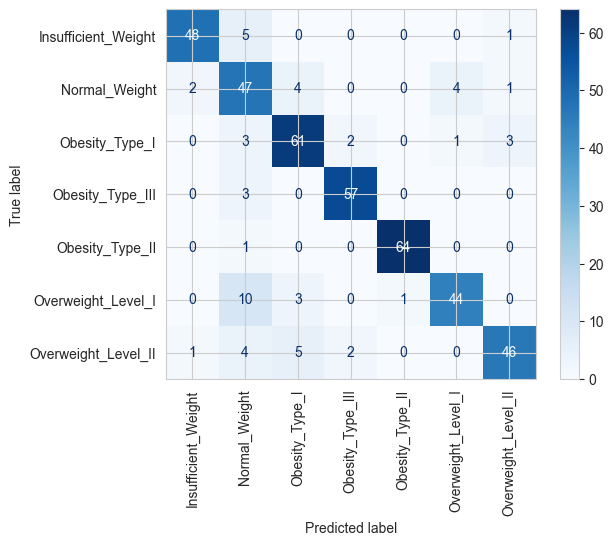

              precision    recall  f1-score   support

           0       0.94      0.89      0.91        54
           1       0.64      0.81      0.72        58
           2       0.84      0.87      0.85        70
           3       0.93      0.95      0.94        60
           4       0.98      0.98      0.98        65
           5       0.90      0.76      0.82        58
           6       0.90      0.79      0.84        58

    accuracy                           0.87       423
   macro avg       0.88      0.87      0.87       423
weighted avg       0.88      0.87      0.87       423



<Figure size 1200x1200 with 0 Axes>

In [99]:
# Fem la matriu de confussió
# Confusion matrix
cm = confusion_matrix(y_test, y_pred) # S'ha de canviar el model al que trobem més òptim
etiquetes_personalitzades = [
    'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 
    'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I', 
    'Overweight_Level_II'
]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=etiquetes_personalitzades)
disp.plot(cmap=plt.cm.Blues,  xticks_rotation='vertical')
plt.show()
plt.figure(figsize=(12, 12))

# Metriques
print (classification_report(y_test, y_pred))